# Pytorch Deep Q Learning (DQN) Tutorial
- Task
:    Cartpole

In [14]:
!pip3 install gymnasium[classic_control]

^C
ERROR: Operation cancelled by user


In [1]:
import os
import torch
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

1
NVIDIA RTX A6000
True


In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Replay Memory

Replay Memory는 Agent가 관찰한 transition을 저장한 뒤, 나중에 재사용할 수 있도록 만든 곳이다.

Replay Memory에 저장한 여러 transition을 나중에 random으로 뽑아, 배치 단위로 학습을 진행하게 된다.

- transition : (state, action, next_state, reward) -> `named tuple`
- ReplayMemory : 가장 최근 관찰한 transition을 저장(push)하고 random으로 뽑는(sample)역할을 하는 클래스이다.

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### DQN algorithm

본 실습에서 사용하는 environment는 deterministic하다. (simplicity를 위해)

본 알고리즘의 목표는 **discounted, cumulative reward**를 최대화하도록 policy를 학습시키는 것이다.

Q-learning의 핵심은 아래의 수식들이다.

*(여기서 * 표시가 붙은 값들은 이상적인 값을 나타낸다)*
$$Q^* : State * Action \rightarrow R \tag{1}$$ 

(1) : Reward는 State와 Action의 곱으로 표현

$$\pi^*(s) = \argmax_a Q^*(s,a) \tag{2}$$

(2) : 최적의 정책 $\pi^*(s)$는 $Q^*(s,a)$를 최대화하는 action

하지만 현재로썬 최적의 정책을 모르므로, 임의의 Q를 만들고 최적의 정책이 될 수 있도록 학습시킨다. 

학습 시에는 Q함수가 Bellman equation을 따른다는 사실을 이용할 것이다.

$$Q^{\pi}(s,a) = r + \gamma Q^{\pi}(s',\pi(s'))$$

temporal difference($\delta$)를 다음과 같이 정의하고 이를 이용해 학습에 사용될 오차(error)를 정의한다.

$$\delta = Q(s,a) - (r + \gamma \max_a' Q(s',a))$$

error를 최소화하기 위해, Huber loss를 이용할 것이다. 

Huber loss는 error의 절대값이 1보다 작거나 같을 경우에는 mean squared error가 되고, 아닐 경우에는 mean absolute error가 된다. 

이를 통해 Q 함수가 outlier가 많을 때에도 robustness를 가질 수 있다.

replay memeory로부터 뽑은 transition의 sample들로 구성된 배치 단위(B)로 학습이 진행된다.

$$\mathcal{L} = {1 \over |B|} \Sigma_{(s,a,s',r) \in B} \mathcal{L}(\delta)$$

$$
\begin{equation}
\mathcal{L}(\delta) =
\begin{cases}
\frac{1}{2} \delta^2 & \text{for } |\delta| \leq 1 \\
|\delta - \frac{1}{2}| & \text{otherwise}
\end{cases}
\end{equation}
$$

### Q-network

간단한 feed forward network를 이용할 것이다.

Cartpole에서 output은 두 가지인데, **Q(s, left) 또는 Q(s, right)** 이다.

즉 network는 주어진 input에 대해 *expected return* 을 예측하도록 학습될 것이다.

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Training
#### Hyperparameters and utilities

- select_action : epsilon greedy policy를 통해 어떤 action을 할 지 선택하는 함수

- plot-duration : 학습의 결과를 보기에 용이하게 plot하는 함수


In [5]:
BATCH_SIZE = 128 # 배치 사이즈 : Replay Memory로부터 sample로 뽑을 transition의 수
GAMMA = 0.99 # 감마 : 감소율
EPS_START = 0.9 : # 입실론의 시작 값
EPS_END = 0.05 # 입실론의 끝 값
EPS_DECAY = 1000 # 입실론의 감소하는 속도
TAU = 0.005 # 타겟 네트워크 업데이트 비율
LR = 1e-4 # 학습률

n_actions = env.action_space.n # gym의 env로부터 액션의 개수 받기 (cartpole에서 2)

state, info = env.reset() # gym의 env로부터 관찰한 값을 받기 (본 코드에서는 state만 이용)
# state에는 Cart Position / Cart Velocity / Pole Angle / Pole Velocity 정보를 담고 있음
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # policy_net(state) 를 통해 DQN의 foward 호출
            # (batch_size, 2) -> (1) -> (1,1)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 episode를 가져와 평균을 내 plot하기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # plot이 update될 수 있는 시간 주기
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [3]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions)) # state는 state끼리, action은 action끼리, next_state는 next_state끼리, reward는 reward끼리 묶는 코드
    # https://stackoverflow.com/a/19343/3343043

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # 학습에 사용할 샘플링된 배치 데이터 중 state가 맨 마지막 state인지 아니면 다음 state가 있는지 알 수 있는 표시 하는 코드
    # batch는 `named tuple`
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
    # INPUT.gather(DIM, INDEX)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


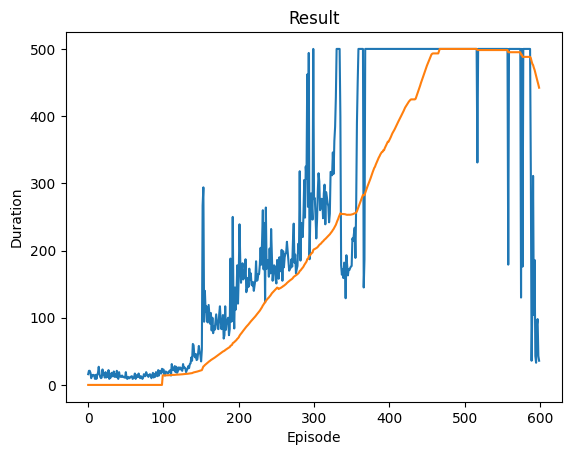

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()